In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# %load mpfin.py
import multiprocessing as mp
import datetime as dt
import time
import sys

def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    multiprocessing snippet [20.7]
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func

    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out


def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts

import datetime as dt

def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return

def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out


In [3]:
# %load labelling.py
import numpy as np
import pandas as pd

def getDailyVol(close, span0=100):
    '''
    Computes the daily volatility of price returns.
    It takes a closing price series, applies a diff sample to sample
    (assumes each sample is the closing price), computes an EWM with 
    `span0` samples and then the standard deviation of it.
    
    See Advances in Financial Analytics, snippet 3.1
    
    @param[in] close A series of prices where each value is the closing price of an asset.
               The index of the series must be a valid datetime type.
    @param[in] span0 The sample size of the EWM.
    @return A pandas series of daily return volatility.
    '''
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values-1 # Daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

def getVerticalBarrier(tEvents, close, numDays=0):
    """
    Adding a Vertical Barrier
    For each index in t_events, it finds the timestamp of the next price bar at or immediately after
    a number of days num_days. This vertical barrier can be passed as an optional argument t1 in get_events.
    This function creates a series that has all the timestamps of when the vertical barrier would be reached.
    
    Advances in Financial Machine Learning, Snippet 3.4 page 49.
    
    @param tEvents A pd.DateTimeIndex of events.
    @param close A pd.Series of close prices.
    @param numDays The number of days to add for vertical barrier.
    @return A pd.Series of Timestamps of vertical barriers
    """
    verticalBarrier = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    verticalBarrier = verticalBarrier[verticalBarrier < close.shape[0]]
    return pd.Series(close.index[verticalBarrier], index = tEvents[:verticalBarrier.shape[0]]) # NaNs at the end

def applyPtSlOnT1(close, events, ptSl, molecule):
    '''
    Apply stop loss/profit taking, if it takes place before t1 (vertical barrier)
    (end of event).
    
    Advances in Financial Machine Learning, snippet 3.2 page 45.
    @param close
    @param events
    @param ptSl
    @param molecule
    @return
    '''
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) # NaNs
    
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl=pd.Series(index=events.index) # NaNs
    
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc,'side'] # path returns
        out.loc[loc,'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt'] = df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
        side_, ptSl_= side.loc[trgt.index],ptSl[:2]
    events = (pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1) .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def getBinsOld(events,close):
    # Snippet 3.5
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # Where out index and t1 (vertical barrier) intersect label 0
    # See page 49, it is a suggested exercise.
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out


def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    
    Snippet 3.7
    
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    
    @param events It's a dataframe whose 
      - index is event's starttime
      - Column t1 is event's endtime
      - Column trgt is event's target
      - Column side (optional) implies the algo's position side.
    @param close It's a close price series.
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:
        out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out


def dropLabels(events, minPct=.05):
    '''
    Takes a dataframe of events and removes those labels that fall
    below minPct (minimum percentil).
    
    Snippet 3.8
    
    @param events An events dataframe, such as the output of getBins()
    @param minPct The minimum percentil of rare labels to have.
    @return The input @p events dataframe but filtered.
    '''
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [4]:
# %load events.py
def cusumFilterEvents(close, threshold):
    '''
    Symmetric CUSUM Filter.
    It is a quality-control method, designed to detect a shift in
    the mean value of the measured quantity away from a target value.
    The value of each filter is:
      S^{+}_t = max{0, S^{+}_{t-1} + y_t - E_{t-1}[y_t]}, S^{+}_0 = 0
      S^{-}_t = mix{0, S^{-}_{t-1} + y_t - E_{t-1}[y_t]}, S^{-}_0 = 0
      S_t = max{S^{+}_t, -S^{-}_t}

    See Advances in Financial Analytics, snippet 2.4, page 39.


    @param close A price series.
    @param threshold A positive threshold to flag a positive or negative
           event when either S^{+}_t or S^{-}_t is greater than it.
    @return A subset of the @p close index series where the events of
            filter are triggered.
    '''
    tEvents = []
    sPos = 0
    sNeg = 0
    
    diff = close.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sNeg < -threshold:
            sNeg = 0
            tEvents.append(i)
        elif sPos > threshold:
            sPos = 0
            tEvents.append(i)
    return pd.to_datetime(tEvents)


def getEwmDf(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a close prices dataframe with three columns, where:
    - Column "close" is the `close` price.
    - Column "fast" is the `fast` EWM with @p fast_window_num_days days window size.
    - Column "slow" is the `slow` EWM with @p slow_window_num_days days window size.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A dataframe as described above.
    '''
    close_df = (pd.DataFrame()
                .assign(close=close)
                .assign(fast=close.ewm(fast_window_num_days).mean())
                .assign(slow=close.ewm(slow_window_num_days).mean()))
    return close_df

def get_up_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

def getEwmEvents(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a pandas series from @p close price series whose events are generated
    from the EWM fast and slow signal crosses. When the fast signal crosses with a
    positive slope the slow signal a "1" is flagged and when the opposite happens
    a "-1" is flagged.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A pandas series of events of buy and sell signals.
    '''
    close_df = getEwmDf(close, fast_window_num_days, slow_window_num_days)
    up_events = get_up_cross(close_df)
    down_events = get_down_cross(close_df)
    side_up = pd.Series(1, index=up_events.index)
    side_down = pd.Series(-1, index=down_events.index)
    return pd.concat([side_up,side_down]).sort_index()
    

In [5]:
# %load frac_diff.py
def getWeights(d,size):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 
    
    @param d A non-negative real that represents the degree of the differentiation.
    @param size The number of items .
    @return A list with the fractionally differentiated coefficients.
    '''
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w


def getWeights_FFD(d,thres):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 
    
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres The minimum absolute value that helps the stop adding items to the list of coefficients.
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    k = 1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_)<thres:
            break
        w.append(w_)
        k+=1
    return np.array(w[::-1]).reshape(-1,1)
                                     
def fracDiff(series, d, thres=0.01):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    value of coefficients the window will have.
    
    @param series A time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df,axis=1)
    return df

def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    coefficient the window will have.
    
    @param series A DataFrame of time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    w = getWeights_FFD(d,thres) # Constant width window (new solution)
    width = len(w)-1
    df={}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0 = seriesF.index[iloc1-width]
            loc1 = seriesF.index[iloc1]
            test_val = series.loc[loc1,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

def compute_multiple_ffd(close, threshold, colname, dd):
    '''
    Iterates over @p close and fractionally differentiates the time series with
    @p dd degree. Uses coefficients whose absolute value is higher than @p threshold.
    
    @param close A DataFrame of time series to apply the fractionally differentiation.
    @param dd A non-negative real series that represents the degree of the differentiation.
    @param threshold A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose columns represent the output of the Augmented Dickey-Fuller statistic.
    '''
    from statsmodels.tsa.stattools import adfuller
    out = pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    df0 = close
    for d in dd:
        print('---Trying {} for {}'.format(d, colname))
        df1 = np.log(df0).resample('1D').last().dropna() # downcast to daily obs. Dropped NAs
        df2 = fracDiff_FFD(df1, d, thres=threshold).dropna()
        # corr = np.corrcoef(df1.loc[df2.index, [colname]], df2[[colname]])[0,1]
        corr = np.corrcoef(df1.loc[df2.index][colname], df2[colname])[0,1]
        df2 = adfuller(df2[colname], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']]+[corr] # with critical value
    return out

def get_d_optim(out, conf=0.05):
    '''
    Returns the maximum differentiation degree that makes the p-value
    of @p out to be less than @p conf.
    
    @param out The output of compute_multiple_ffd().
    @param conf The confidence value.
    @return The optimal differentiation degree.
    '''
    return out[out.pVal < conf].pVal.idxmax()

In [6]:
# %load sample_weights.py
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    
    Any event that starts before t1[modelcule].max() impacts the count.
    
    See Advances in Financial Analytics, snippet 4.1, page 60.
    
    @param closeIdx An index series of close prices. It must be related with `t1`.
    @param t1 An index series of vertical barrier events.
    @param molecule Event' series index.
           molecule[0] is the date of the first event on which the weight will be computed.
           molecule[-1] is the date of the last event on which the weight will be computed.
    @return A series with overlaps counts whose index is the same as t1.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():
        count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]


def mpSampleTW(t1,numCoEvents,molecule):
    '''
    Computes the sample weight of an event as the reciprocal of the hsrmonic average
    of c_t over the event's lifespan.
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    
    @param t1 An index series of vertical barrier events.
    @param numCoEvents The output of mpNumCoEvents()
    @param molecule Event' series index.
    @return A series of weights for each event in t1.
    '''
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

def mpSampleW(t1,numCoEvents,close,molecule):
    '''
    Derive sample weight by return attribution
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    ''' 
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

def getTimeDecay(tW,clfLastW=1.):
    '''
    Apply piecewise-linear decay to observed uniqueness (tW)
    Newest observation gets weight=1, oldest observation gets weight=clfLastW
    '''
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    # print(const,slope)
    return clfW

def getIndMatrix(barIx,t1):
    '''
    Get Indicator matrix
    
    See Advances in Financial Analytics, snippet 4.3, page 64.
    '''
    indM=(pd.DataFrame(0,index=barIx,columns=range(t1.shape[0])))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

def getAvgUniqueness(indM):
    '''
    Average uniqueness from indicator matrix
    
    See Advances in Financial Analytics, snippet 4.4, page 65.
    '''
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # avg. uniqueness
    return avgU

def seqBootstrap(indM,sLength=None):
    '''
    Generate a sample via sequential bootstrap
    
    See Advances in Financial Analytics, snippet 4.5, page XX.
    '''
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

In [7]:
# %load features.py
import numpy as np


def rsi(close, window_length=14):
    """
    Computes the RSI index over a price series sampled at constant time step.

    @param close A series that contains the close price values.
    @param window_length The number of events to apply an average.
    @return A series that contains the RSI index of the close price series.
    """
    # Get the difference in price from previous step
    delta = close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous
    # row to calculate the differences
    delta = delta[1:]
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    # Calculate the SMA
    roll_up = up.rolling(window_length).mean()
    roll_down = down.abs().rolling(window_length).mean()
    # Calculate the RSI based on SMA
    relative_strength = roll_up / roll_down
    return 100.0 - (100.0 / (1.0 + relative_strength))


def log_ret(close):
    """
    Computes the log of the returns inter sample.

    @param close A series that contains the close price values.
    @return A series that contains the log of the inter sample returns
    """
    return np.log(close).diff()


def autocorr(close, window_length=50, lag=1):
    """
    Computes the auto correlation of the price series.

    @param close A series that contains the close price values.
    @param window_length The window size.
    @param lag The lag positions to consider when computing the auto correlation.
    @return A series that contains the auto correlation.
    """
    log_ret_series = log_ret(close)
    return \
        log_ret_series.rolling(window=window_length,
                               min_periods=window_length,
                               center=False).apply(lambda x: x.autocorr(lag=1), raw=False)


def volatility(close, window_length=50):
    """
    Computes the rolling volatility of prices for a given window length.

    @param close A series that contains the close price values.
    @param window_length The window size.
    @return A series of price volatility.
    """
    log_ret_series = log_ret(close)
    return \
        log_ret_series.rolling(window=window_length,
                               min_periods=window_length,
                               center=False).std()


In [8]:
BTC_PATH = '../datasets/bitstamp_data_daily.csv'

In [9]:
# Función que permite convertir el formato de las fechas como unix time
# en un objeto de fecha.
def unix_time_to_date(x): return pd.to_datetime(x, unit='s')

In [10]:
btc = pd.read_csv(BTC_PATH, parse_dates=['Timestamp'], date_parser=unix_time_to_date, index_col='Timestamp')

In [11]:
btc.head() # Filas iniciales del dataset

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
Timestamp,,,,,,
2011-12-30 03:00:00,4.39,4.58,4.39,4.58,95.317878,425.320338
2011-12-31 03:00:00,4.58,5.00,4.58,5.00,21.602000,105.779160
2012-01-01 03:00:00,5.00,5.00,5.00,5.00,19.048000,95.240000
2012-01-02 03:00:00,5.32,5.32,5.14,5.29,88.037281,464.805210
2012-01-03 03:00:00,4.93,5.57,4.93,5.57,107.233260,568.076197


In [12]:
btc.tail() # Filas finales del dataset

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
Timestamp,,,,,,
2020-12-26 03:00:00,26472.89,28377.94,25770.00,26259.60,13234.334129,3.584020e+08
2020-12-27 03:00:00,26242.82,27473.49,26079.60,27037.91,7987.777611,2.153717e+08
2020-12-28 03:00:00,27037.90,27395.00,25831.85,27370.00,9577.278292,2.552738e+08
2020-12-29 03:00:00,27370.00,29010.32,27328.37,28881.30,11741.733381,3.308799e+08
2020-12-30 03:00:00,28893.21,28928.49,28893.21,28928.49,5.757679,1.664497e+05


In [13]:
# [#Filas, #Columnas]
btc.shape[0], btc.shape[1]

(3289, 6)

In [14]:
# Tipo de dato de cada columna.
btc.dtypes

Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
dtype: object

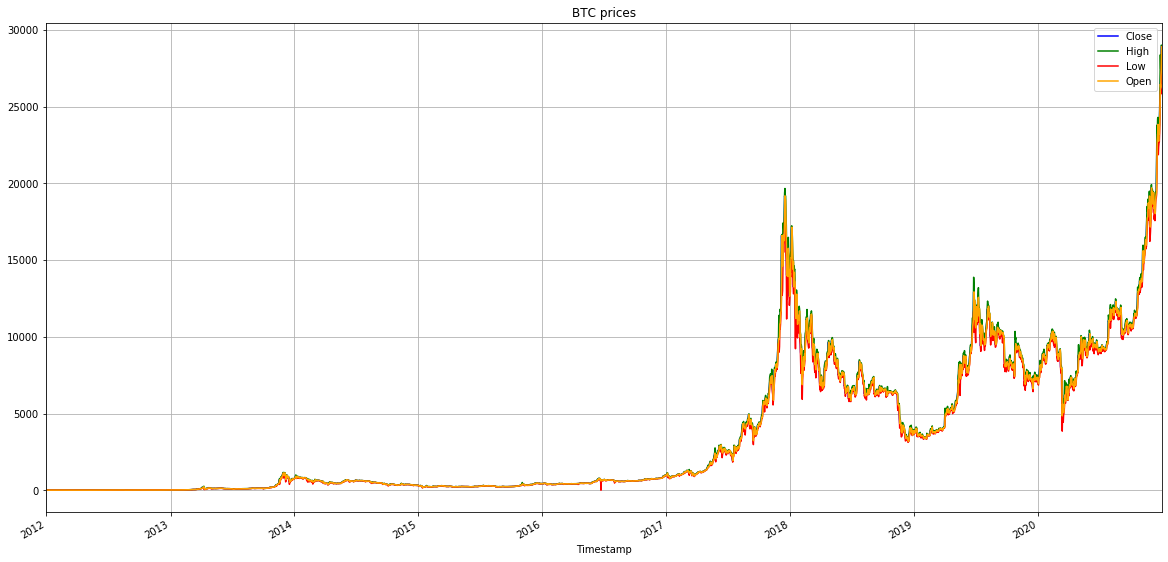

In [15]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='Close', color='blue', ax=ax)
btc.plot(kind='line',y='High', color='green', ax=ax)
btc.plot(kind='line',y='Low', color='red', ax=ax)
btc.plot(kind='line',y='Open', color='orange', ax=ax)
plt.title('BTC prices')
plt.grid()
plt.show()

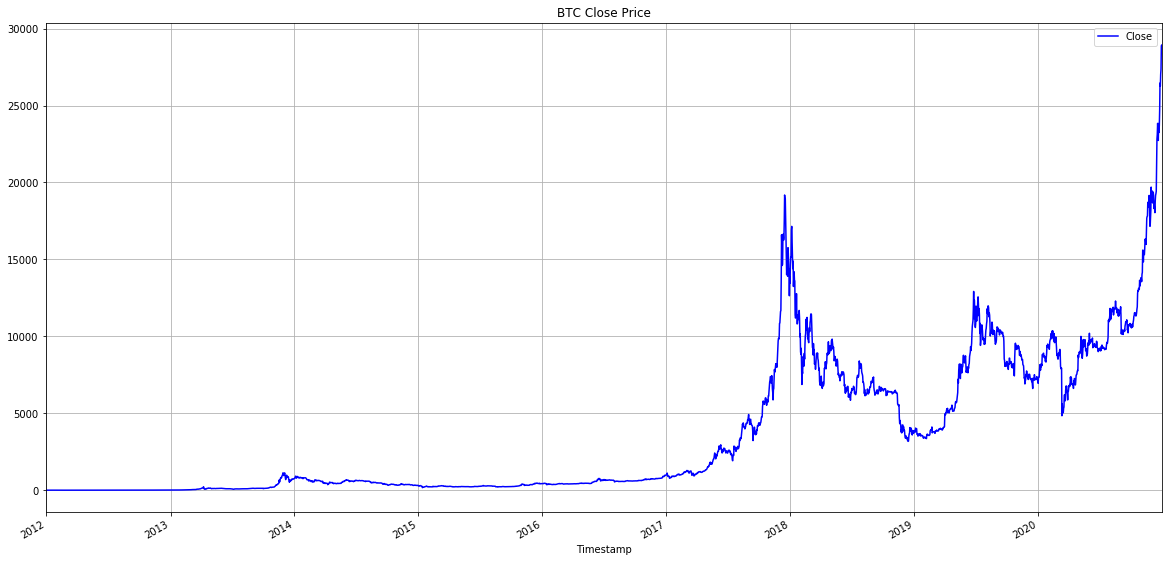

In [16]:
# En particular los va a interesar el precio de cierre.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='Close', color='blue', ax=ax)
plt.title('BTC Close Price')
plt.grid()
plt.show()

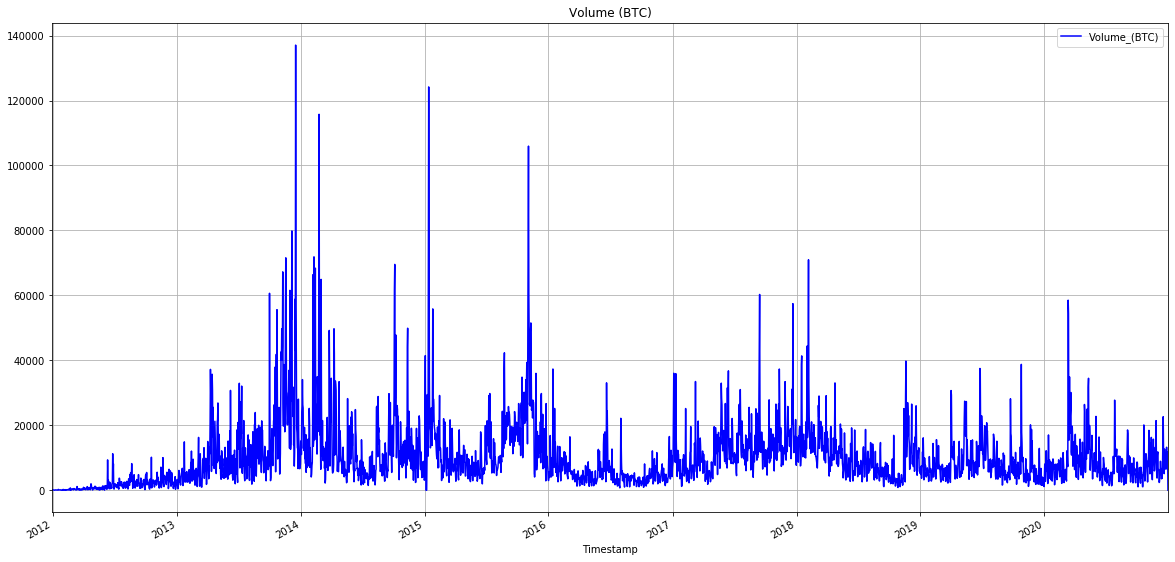

In [17]:
# Solo para comparar, miramos el volumen operado.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='Volume_(BTC)', color='blue', ax=ax)
plt.title('Volume (BTC)')
plt.grid()
plt.show()

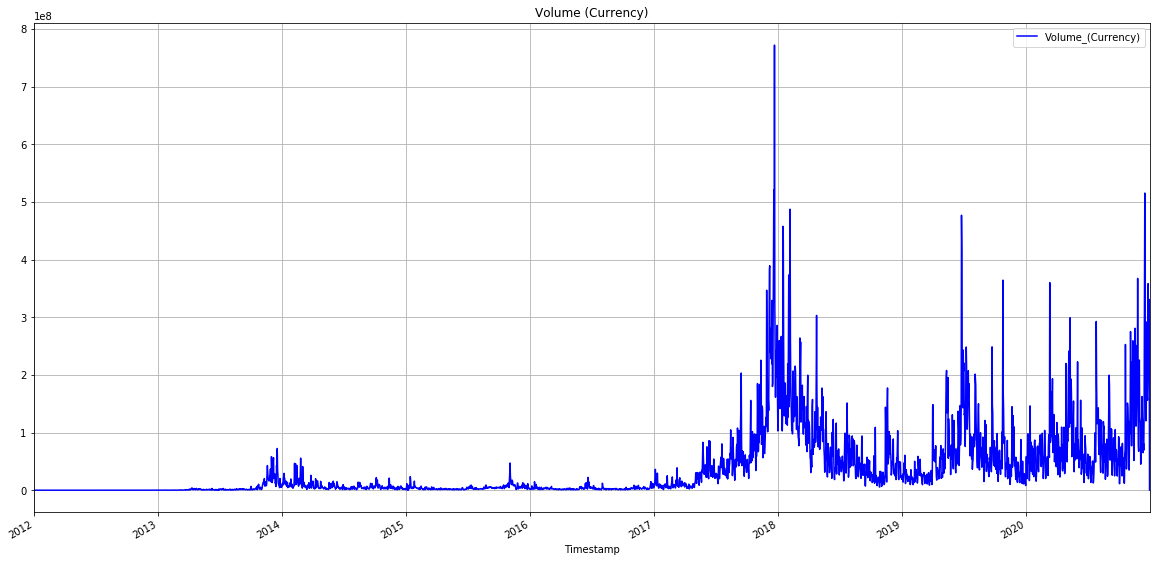

In [18]:
# Solo para comparar, miramos el volumen operado pero en USD.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='Volume_(Currency)', color='blue', ax=ax)
plt.title('Volume (Currency)')
plt.grid()
plt.show()

In [19]:
# Computamos la volatilidad diaria, suavizada con una media
# movil pesada de 50 dias (arbitraria, también se podria aprender)
daily_vol = getDailyVol(close=btc['Close'], span0=50)

In [20]:
# Volatilidad minima, media y maxima.
daily_vol.min(), daily_vol.mean(), daily_vol.max()

(0.016608586177643547, 0.055109222882186476, 0.22694997608195852)

In [21]:
# Los quantiles de la volatilidad.
daily_vol.quantile([0.05, 0.10, 0.20, 0.50, 0.75, 0.9, 0.95])

0.05    0.023051
0.10    0.027029
0.20    0.034173
0.50    0.048911
0.75    0.065681
0.90    0.090212
0.95    0.101092
Name: Close, dtype: float64

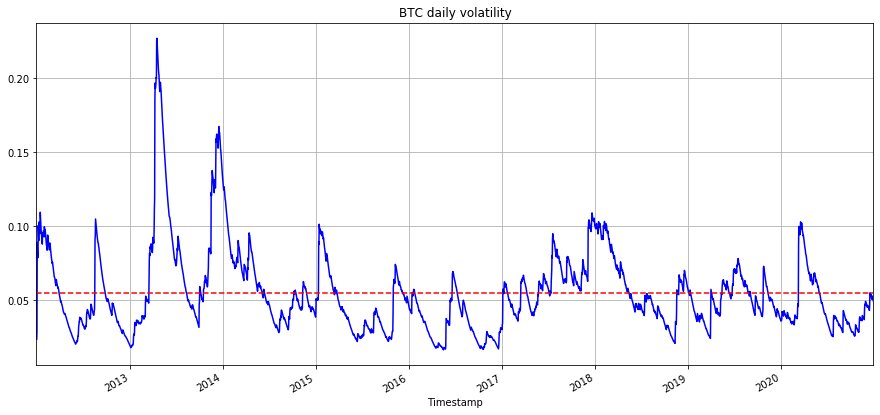

In [22]:
# Graficamos la volatilidad a lo largo de la historia de BTC.
# La línea roja muestra el valor medio.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
daily_vol.plot(kind='line',y='dailyVol', color='blue', ax=ax)
ax.axhline(daily_vol.mean(),ls='--',color='r')
plt.title('BTC daily volatility')
plt.grid()
plt.show()

## Modelo para los labels y la generacion del dataset de metalabels

In [23]:
# Computamos los eventos de cruce de media moviles (a optimizar!)
fast_window_num_days = 2
slow_window_num_days = 5
tEvents = getEwmEvents(btc['Close'], fast_window_num_days, slow_window_num_days)
tEvents

# Definimos el tiempo de la barrera vertical. Esto es algo a optimizar
# y debe ajustarse en conjunto con los valores de retorno PT y SL.
num_days = 6

# Computamos las marcas temporales de la ventana. Para cada evento
# en tEvents (inicio de la ventana), obtenemos el final de la ventana.
# Nota: a diferencia de la notebook con labelling unicamente, tEvents 
#       aquí es una serie con el side de la apuesta por lo que debemos
#       pasar el indice a getVerticalBarrier() para reutilizar la funcion.
t1 = getVerticalBarrier(tEvents.index, btc['Close'], numDays=num_days)
print("Barreras verticales para los eventos cruce de medias:")
print(t1)

# Definimos las bandas de PT y SL.
ptSl = [0.5, 0.4]
# Computamos la volatilidad diaria, suavizada con una media
# movil pesada de 50 dias (arbitraria, también se podria aprender)
target = getDailyVol(close=btc['Close'], span0=50)
# Seleccionamos el mínimo retorno considerado.
minRet = 0.025
# Numero de CPUs para el procesamiento en paralelo. 
cpus = 4

# Generamos los eventos de la triple frontera. En esta funcion obtenemos
# un dataframe cuyo indice es cuando ocurre el evento y tiene 2 columnasÑ
# - t1: momento en el que sucede el evento.
# - trgt: retorno obtenido en ese momento.
triple_barrier_events = getEvents(btc['Close'],tEvents.index,ptSl,target,minRet,cpus,t1=t1,side=tEvents)
print("Eventos de triple frontera y retorno obtenido: ")
print(triple_barrier_events)

# Obtenemos los labels! Los labels nos dan la siguiente informacion:
# - Indice: momento en el que ocurre el evento segun nuestra estrategia.
# - Columna ret: el retorno que vamos a obtener.
# - Columna bin: lo que sucede con la señal de la apuesta:
#   - 1: se toma la apuesta.
#   - 0: no se toma la apuesta.
labels = getBins(triple_barrier_events, btc['Close'])
print("Labels para triple frontera: ")
print(labels)

# Una pequeña tabla de contención que nos indica como se distribuyen
# los labels.
print(labels['bin'].value_counts())

Barreras verticales para los eventos cruce de medias:
Timestamp
2012-01-18 03:00:00   2012-01-24 03:00:00
2012-01-19 03:00:00   2012-01-25 03:00:00
2012-01-23 03:00:00   2012-01-29 03:00:00
2012-02-02 03:00:00   2012-02-08 03:00:00
2012-02-04 03:00:00   2012-02-10 03:00:00
                              ...        
2020-10-04 03:00:00   2020-10-10 03:00:00
2020-10-05 03:00:00   2020-10-11 03:00:00
2020-10-07 03:00:00   2020-10-13 03:00:00
2020-12-09 03:00:00   2020-12-15 03:00:00
2020-12-12 03:00:00   2020-12-18 03:00:00
Name: Timestamp, Length: 214, dtype: datetime64[ns]
Eventos de triple frontera y retorno obtenido: 
                                     t1      trgt  side
Timestamp                                              
2012-01-18 03:00:00 2012-01-19 03:00:00  0.101074  -1.0
2012-01-19 03:00:00 2012-01-22 03:00:00  0.098222   1.0
2012-01-23 03:00:00 2012-01-25 03:00:00  0.089983  -1.0
2012-02-02 03:00:00 2012-02-03 03:00:00  0.097922   1.0
2012-02-04 03:00:00 2012-02-07 03:00:0

2021-11-22 13:19:32.573460 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.


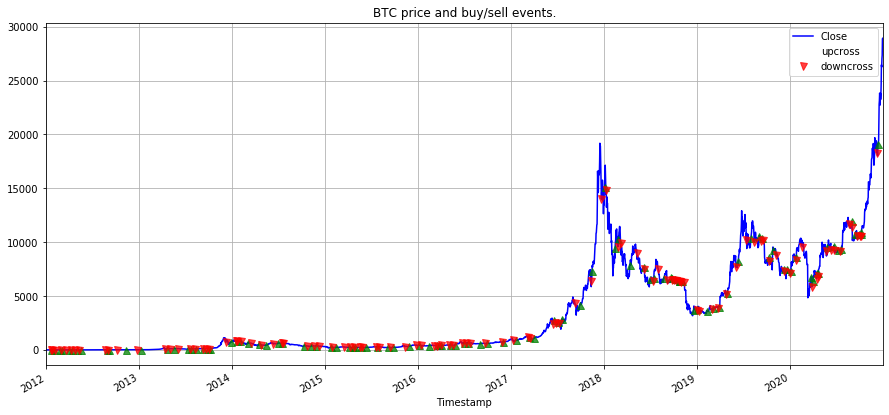

In [24]:
# Graficamos la serie de precios agregando unas flechas de color que indique
# el signo de la apuesta.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
btc.plot(kind='line',y='Close', color='blue', ax=ax)
btc.loc[tEvents[tEvents == 1].index].plot(
    ax=ax,ls='',marker='^', markersize=7, alpha=0.75, label='upcross', color='g', y='Close')
btc.loc[tEvents[tEvents == -1].index].plot(
    ax=ax,ls='',marker='v', markersize=7, alpha=0.75, label='downcross', color='r', y='Close')
plt.title('BTC price and buy/sell events.')
plt.grid()
plt.show()

## Uniqueness para el entrenamiento de metalabels

In [25]:
# Obtengo los coeficientes de concurrencia para cada evento.
numCoEvents = mpPandasObj(mpNumCoEvents,('molecule',triple_barrier_events.index),cpus,
                          closeIdx=btc.index,t1=triple_barrier_events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(btc['Close'].index).fillna(0)

# Genero un data frame que contenga en una columna los pesos por concurrencia
# y en otra los pesos por concurrencia + retornos.
out=pd.DataFrame()
out['tW'] = mpPandasObj(mpSampleTW,('molecule',triple_barrier_events.index),cpus,
                        t1=triple_barrier_events['t1'],numCoEvents=numCoEvents)
out['w'] = mpPandasObj(mpSampleW,('molecule',triple_barrier_events.index),cpus,
                       t1=triple_barrier_events['t1'],numCoEvents=numCoEvents,close=btc['Close'])
out['w'] *= out.shape[0]/out['w'].sum()
averageUniqueness = out.mean()[0]
print("Dataframe de concurrencia de eventos en ventanas de triple frontera: ")
print(out)
print("Average uniqueness: ")
print(averageUniqueness)


# Genero un data frame entre las concurrencias y los retornos diarios.
coEvents_std = (pd.DataFrame().assign(numCoEvents = numCoEvents, std = target))
print("Dataframe de concurrencia de eventos en ventanas de triple frontera y volatilidad")
print(coEvents_std)
print(coEvents_std.loc[:, "numCoEvents"].value_counts())

2021-11-22 13:19:35.397297 100.0% mpNumCoEvents done after 0.0 minutes. Remaining 0.0 minutes.
2021-11-22 13:19:35.520469 100.0% mpSampleTW done after 0.0 minutes. Remaining 0.0 minutes.


Dataframe de concurrencia de eventos en ventanas de triple frontera: 
                           tW         w
2012-01-18 03:00:00  0.750000  1.503227
2012-01-19 03:00:00  0.875000  0.163968
2012-01-23 03:00:00  1.000000  3.328238
2012-02-02 03:00:00  1.000000  1.088912
2012-02-04 03:00:00  1.000000  0.231914
...                       ...       ...
2020-10-04 03:00:00  0.500000  0.058205
2020-10-05 03:00:00  0.666667  0.175028
2020-10-07 03:00:00  0.833333  0.893950
2020-12-09 03:00:00  1.000000  0.271152
2020-12-12 03:00:00  1.000000  2.486479

[199 rows x 2 columns]
Average uniqueness: 
0.9204113823083672
Dataframe de concurrencia de eventos en ventanas de triple frontera y volatilidad
                     numCoEvents       std
Timestamp                                 
2011-12-30 03:00:00          0.0       NaN
2011-12-31 03:00:00          0.0       NaN
2012-01-01 03:00:00          0.0       NaN
2012-01-02 03:00:00          0.0  0.023832
2012-01-03 03:00:00          0.0  0.028431
...

2021-11-22 13:19:35.721823 100.0% mpSampleW done after 0.0 minutes. Remaining 0.0 minutes.


## Diferenciacion fraccionaria

---Trying 0.0 for Close
---Trying 0.05 for Close
---Trying 0.1 for Close
---Trying 0.15000000000000002 for Close
---Trying 0.2 for Close
---Trying 0.25 for Close
---Trying 0.30000000000000004 for Close
---Trying 0.35000000000000003 for Close
---Trying 0.4 for Close
---Trying 0.45 for Close
---Trying 0.5 for Close
---Trying 0.55 for Close
---Trying 0.6000000000000001 for Close
---Trying 0.65 for Close
---Trying 0.7000000000000001 for Close
---Trying 0.75 for Close
---Trying 0.8 for Close
---Trying 0.8500000000000001 for Close
---Trying 0.9 for Close
---Trying 0.9500000000000001 for Close
---Trying 1.0 for Close
        adfStat          pVal  lags    nObs  95% conf      corr
0.00  -1.586943  4.901489e-01   1.0  3284.0 -2.862421  1.000000
0.05  -1.504320  5.313735e-01   1.0  3244.0 -2.862431  0.999948
0.10  -1.688057  4.372759e-01   1.0  3223.0 -2.862437  0.999591
0.15  -1.714307  4.237564e-01   1.0  3213.0 -2.862440  0.998683
0.20  -1.802431  3.792553e-01   1.0  3212.0 -2.862440  0.99716

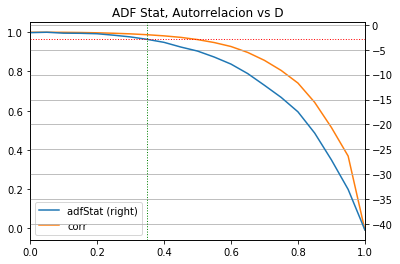

In [26]:
# Computo una lista de valores de d (el grado de diferenciación),
# y diferencio la serie de precios.
ds = np.linspace(0, 1, 21)
out = compute_multiple_ffd(btc['Close'].to_frame(), 1e-3, 'Close', ds)
print(out)

# Realizamos un plot para evaluar gráficamente el valor óptimo.
out[['adfStat','corr']].plot(secondary_y='adfStat')
mean_95conf = out['95% conf'].mean()
optim_d = get_d_optim(out, conf=0.05)
plt.axhline(mean_95conf,linewidth=1,color='r',linestyle='dotted')
plt.axvline(optim_d,linewidth=1,color='g',linestyle='dotted')
plt.grid()
plt.title('ADF Stat, Autorrelacion vs D')
print('Promedio de valores críticos para el estadístico al 5%: {}'.format(mean_95conf))
print('Valor óptimo de d: {}'.format(optim_d))

In [27]:
def ffd_optim_sample(ds, input_df, colname, threshold=1e-3):
    out = compute_multiple_ffd(input_df.to_frame(), threshold, colname, ds)
    optim_d = get_d_optim(out, conf=0.05)
    return optim_d, fracDiff_FFD(input_df.to_frame(), d=optim_d, thres=threshold)

In [28]:
close_optim_d, btc['CloseFFD'] = ffd_optim_sample(ds, btc['Close'], 'Close', threshold=1e-3)
open_optim_d, btc['OpenFFD'] = ffd_optim_sample(ds, btc['Open'], 'Open', threshold=1e-3)
high_optim_d, btc['HighFFD'] = ffd_optim_sample(ds, btc['High'], 'High', threshold=1e-3)
low_optim_d, btc['LowFFD'] = ffd_optim_sample(ds, btc['Low'], 'Low', threshold=1e-3)

---Trying 0.0 for Close
---Trying 0.05 for Close
---Trying 0.1 for Close
---Trying 0.15000000000000002 for Close
---Trying 0.2 for Close
---Trying 0.25 for Close
---Trying 0.30000000000000004 for Close
---Trying 0.35000000000000003 for Close
---Trying 0.4 for Close
---Trying 0.45 for Close
---Trying 0.5 for Close
---Trying 0.55 for Close
---Trying 0.6000000000000001 for Close
---Trying 0.65 for Close
---Trying 0.7000000000000001 for Close
---Trying 0.75 for Close
---Trying 0.8 for Close
---Trying 0.8500000000000001 for Close
---Trying 0.9 for Close
---Trying 0.9500000000000001 for Close
---Trying 1.0 for Close
---Trying 0.0 for Open
---Trying 0.05 for Open
---Trying 0.1 for Open
---Trying 0.15000000000000002 for Open
---Trying 0.2 for Open
---Trying 0.25 for Open
---Trying 0.30000000000000004 for Open
---Trying 0.35000000000000003 for Open
---Trying 0.4 for Open
---Trying 0.45 for Open
---Trying 0.5 for Open
---Trying 0.55 for Open
---Trying 0.6000000000000001 for Open
---Trying 0.65 f

In [29]:
close_optim_d, open_optim_d, high_optim_d, low_optim_d

(0.35000000000000003,
 0.35000000000000003,
 0.35000000000000003,
 0.15000000000000002)

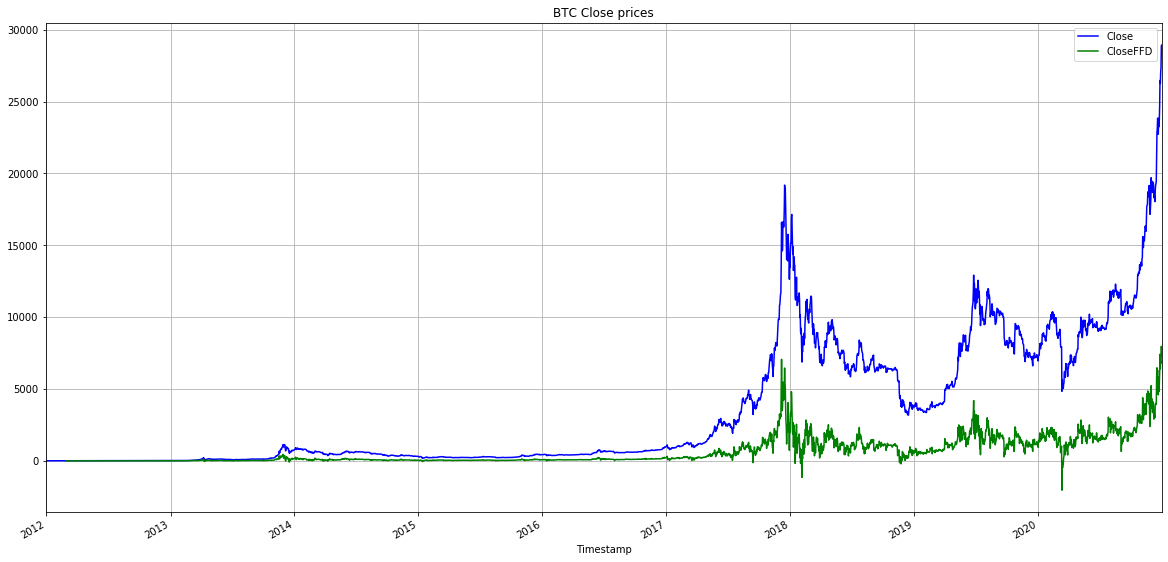

In [30]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='Close', color='blue', ax=ax)
btc.plot(kind='line',y='CloseFFD', color='green', ax=ax)
plt.title('BTC Close prices')
plt.grid()
plt.show()

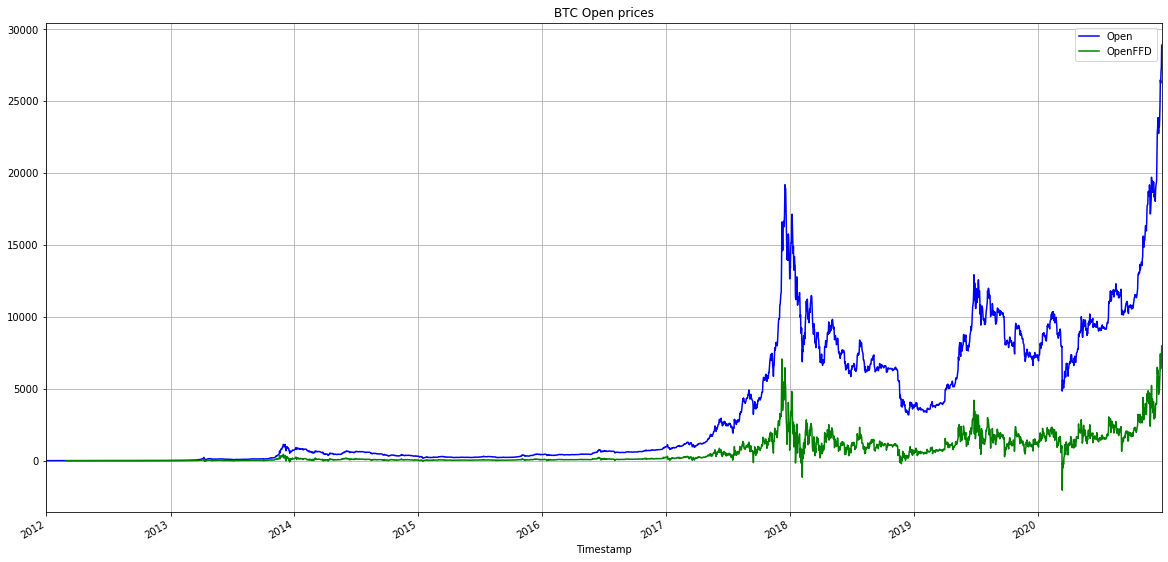

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='Open', color='blue', ax=ax)
btc.plot(kind='line',y='OpenFFD', color='green', ax=ax)
plt.title('BTC Open prices')
plt.grid()
plt.show()

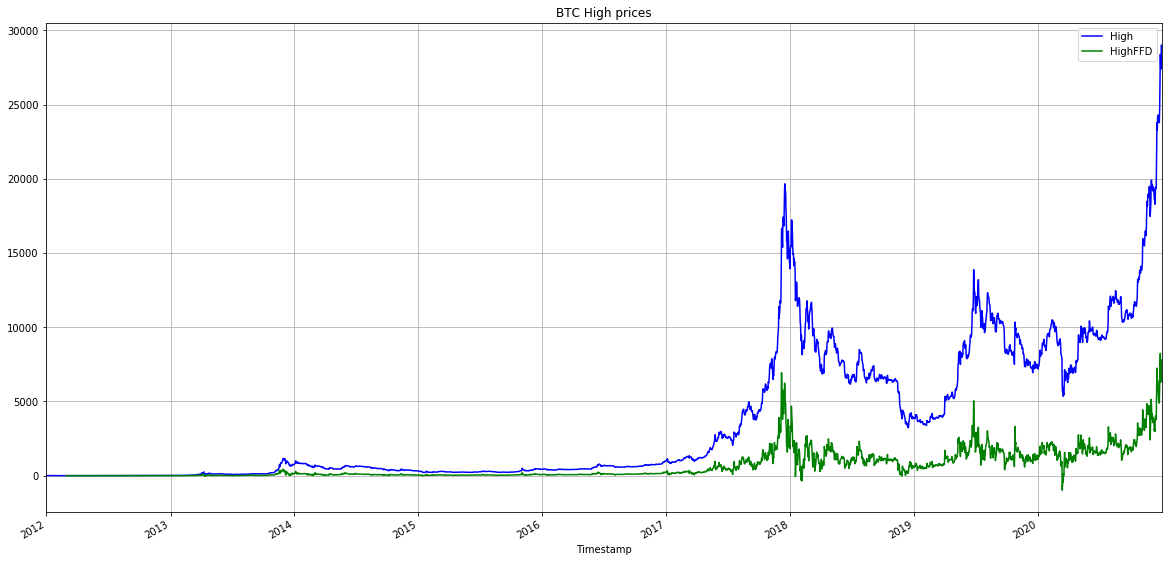

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='High', color='blue', ax=ax)
btc.plot(kind='line',y='HighFFD', color='green', ax=ax)
plt.title('BTC High prices')
plt.grid()
plt.show()

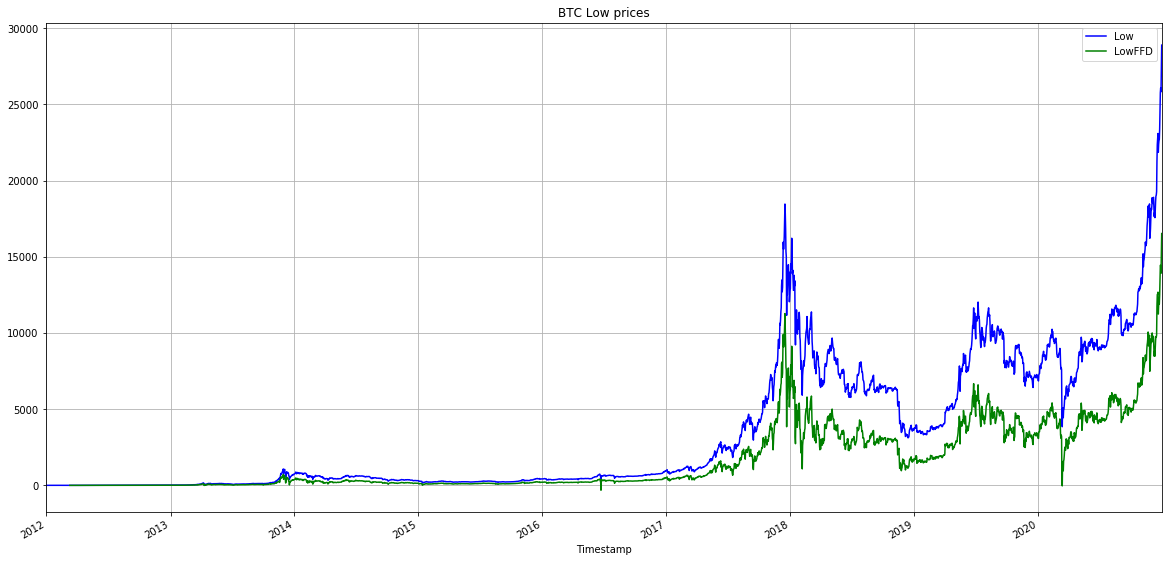

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
btc.plot(kind='line',y='Low', color='blue', ax=ax)
btc.plot(kind='line',y='LowFFD', color='green', ax=ax)
plt.title('BTC Low prices')
plt.grid()
plt.show()

In [34]:
# Computamos la volatilidad diaria, suavizada con una media
# movil pesada de 50 dias (arbitraria, también se podria aprender)
daily_vol = getDailyVol(close=btc['CloseFFD'], span0=50)
                        
# Usamos CUSUM simetrico como generador de eventos.
# Usamos la media de la volatilidad como umbral que nos indique los eventos
# en que el que operaremos.
tEvents = cusumFilterEvents(btc['CloseFFD'], threshold=3.*daily_vol.mean())
print(tEvents)

# Definimos el tiempo de la barrera vertical. Esto es algo a optimizar
# y debe ajustarse en conjunto con los valores de retorno PT y SL.
num_days = 6

# Computamos las marcas temporales de la ventana. Para cada evento
# en tEvents (inicio de la ventana), obtenemos el final de la ventana.
t1 = getVerticalBarrier(tEvents, btc['CloseFFD'], numDays=num_days)
print(t1)

# Definimos las bandas de PT y SL.
ptsl = [1,1]
target = daily_vol
# Seleccionamos el mínimo retorno considerado.
minRet = daily_vol.quantile([0.1])[0.1]
# Numero de CPUs para el procesamiento en paralelo. 
cpus = 4

# Generamos los eventos de la triple frontera. En esta funcion obtenemos
# un dataframe cuyo indice es cuando ocurre el evento y tiene 2 columnas
# - t1: momento en el que sucede el evento.
# - trgt: retorno obtenido en ese momento.
triple_barrier_events = getEvents(btc['CloseFFD'],tEvents,ptsl,target,minRet,cpus,t1=t1)
print(triple_barrier_events)

# Obtenemos los labels! Los labels nos dan la siguiente informacion:
# - Indice: momento en el que ocurre el evento segun nuestra estrategia.
# - Columna ret: el retorno que vamos a obtener.
# - Columna bin: lo que sucede con la señal de precio:
#   - 1: la señal impacta la barrera de profit taking (horizontal superior).
#   - 0: la señal impacta la barrera vertical (no se hace nada).
#   - -1: la señal impacta la barrea de stop loss (horizontal inferior).
labels = getBinsOld(triple_barrier_events, btc['CloseFFD'])
print(labels)
print(labels['bin'].value_counts())

DatetimeIndex(['2013-01-20 03:00:00', '2013-02-27 03:00:00',
               '2013-03-08 03:00:00', '2013-03-18 03:00:00',
               '2013-03-20 03:00:00', '2013-03-21 03:00:00',
               '2013-03-22 03:00:00', '2013-03-23 03:00:00',
               '2013-03-26 03:00:00', '2013-03-27 03:00:00',
               ...
               '2020-12-21 03:00:00', '2020-12-22 03:00:00',
               '2020-12-23 03:00:00', '2020-12-24 03:00:00',
               '2020-12-25 03:00:00', '2020-12-26 03:00:00',
               '2020-12-27 03:00:00', '2020-12-28 03:00:00',
               '2020-12-29 03:00:00', '2020-12-30 03:00:00'],
              dtype='datetime64[ns]', length=2182, freq=None)
2013-01-20 03:00:00   2013-01-26 03:00:00
2013-02-27 03:00:00   2013-03-05 03:00:00
2013-03-08 03:00:00   2013-03-14 03:00:00
2013-03-18 03:00:00   2013-03-24 03:00:00
2013-03-20 03:00:00   2013-03-26 03:00:00
                              ...        
2020-12-20 03:00:00   2020-12-26 03:00:00
2020-12-21 03:

2021-11-22 13:24:57.048132 100.0% applyPtSlOnT1 done after 0.02 minutes. Remaining 0.0 minutes.


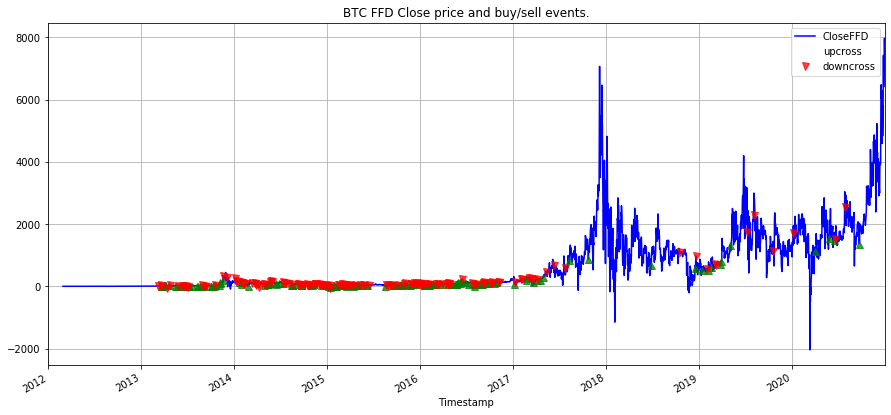

In [35]:
# Graficamos la serie de precios agregando unas flechas de color que indique
# el signo de la apuesta.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
btc.plot(kind='line',y='CloseFFD', color='blue', ax=ax)
btc.loc[labels[labels['bin'] == 1].index].plot(
    ax=ax,ls='',marker='^', markersize=7, alpha=0.75, label='upcross', color='g', y='CloseFFD')
btc.loc[labels[labels['bin'] == -1].index].plot(
    ax=ax,ls='',marker='v', markersize=7, alpha=0.75, label='downcross', color='r', y='CloseFFD')
plt.title('BTC FFD Close price and buy/sell events.')
plt.grid()
plt.show()

In [36]:
# Obtengo los coeficientes de concurrencia para cada evento.
numCoEvents = mpPandasObj(mpNumCoEvents,('molecule',triple_barrier_events.index),cpus,
                          closeIdx=btc.index,t1=triple_barrier_events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(btc['CloseFFD'].index).fillna(0)

# Genero un data frame que contenga en una columna los pesos por concurrencia
# y en otra los pesos por concurrencia + retornos.
out=pd.DataFrame()
out['tW'] = mpPandasObj(mpSampleTW,('molecule',triple_barrier_events.index),cpus,
                        t1=triple_barrier_events['t1'],numCoEvents=numCoEvents)
out['w'] = mpPandasObj(mpSampleW,('molecule',triple_barrier_events.index),cpus,
                       t1=triple_barrier_events['t1'],numCoEvents=numCoEvents,close=btc['Close'])
out['w'] *= out.shape[0]/out['w'].sum()
averageUniqueness = out.mean()[0]
print("Dataframe de concurrencia de eventos en ventanas de triple frontera: ")
print(out)
print("Average uniqueness: ")
print(averageUniqueness)


# Genero un data frame entre las concurrencias y los retornos diarios.
coEvents_std = (pd.DataFrame().assign(numCoEvents = numCoEvents, std = target))
print("Dataframe de concurrencia de eventos en ventanas de triple frontera y volatilidad")
print(coEvents_std)
print(coEvents_std.loc[:, "numCoEvents"].value_counts())

2021-11-22 13:24:57.875970 100.0% mpNumCoEvents done after 0.01 minutes. Remaining 0.0 minutes.
2021-11-22 13:24:58.188170 100.0% mpSampleTW done after 0.0 minutes. Remaining 0.0 minutes.


Dataframe de concurrencia de eventos en ventanas de triple frontera: 
                           tW          w
2013-03-08 03:00:00  1.000000   1.306465
2013-03-18 03:00:00  0.833333  16.179447
2013-03-20 03:00:00  0.444444   0.676038
2013-03-21 03:00:00  0.416667   2.481615
2013-03-22 03:00:00  0.416667   0.923912
...                       ...        ...
2020-12-26 03:00:00  0.237500   0.862108
2020-12-27 03:00:00       NaN   0.000000
2020-12-28 03:00:00       NaN   0.000000
2020-12-29 03:00:00       NaN   0.000000
2020-12-30 03:00:00       NaN   0.000000

[2072 rows x 2 columns]
Average uniqueness: 
0.22946638790979065
Dataframe de concurrencia de eventos en ventanas de triple frontera y volatilidad
                     numCoEvents       std
Timestamp                                 
2011-12-30 03:00:00          0.0       NaN
2011-12-31 03:00:00          0.0       NaN
2012-01-01 03:00:00          0.0       NaN
2012-01-02 03:00:00          0.0       NaN
2012-01-03 03:00:00          0.0

2021-11-22 13:24:58.654727 100.0% mpSampleW done after 0.01 minutes. Remaining 0.0 minutes.


In [37]:
labels_filtered = dropLabels(labels, minPct=0.05)
labels_filtered['bin'].value_counts()

 0.0    1767
 1.0     159
-1.0     141
Name: bin, dtype: int64

In [38]:
labels_filtered = dropLabels(labels, minPct=0.10)
labels_filtered['bin'].value_counts()

dropped label:  -1.0 0.06821480406386067


/home/agustin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:162: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/home/agustin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


0.0    1767
1.0     159
Name: bin, dtype: int64

In [39]:
triple_barrier_events2 = triple_barrier_events.copy(deep=True)
triple_barrier_events2['side'] = labels['bin']

In [40]:
meta_label = getBins(triple_barrier_events2, btc['CloseFFD'])
print(meta_label)
print(meta_label['bin'].value_counts())

                          ret  bin
2013-03-08 03:00:00  0.302573  1.0
2013-03-18 03:00:00  0.279219  1.0
2013-03-20 03:00:00  0.486274  1.0
2013-03-21 03:00:00  0.328792  1.0
2013-03-22 03:00:00  0.527052  1.0
...                       ...  ...
2020-12-21 03:00:00  0.000000  0.0
2020-12-22 03:00:00  0.000000  0.0
2020-12-23 03:00:00  0.000000  0.0
2020-12-24 03:00:00  0.000000  0.0
2020-12-26 03:00:00  0.000000  0.0

[2067 rows x 2 columns]
0.0    1767
1.0     300
Name: bin, dtype: int64


## Agrego features tecnicas

In [41]:
RSI_WINDOW_LENGTHS = [5, 10, 15, 30]            # RSI
AUTOCORR_LAGS = [1, 3, 5]                       # Auto correlation.
AUTOCORR_WINDOW_LENGTH = 45
VOLATILITY_WINDOW_LENGTHS = [5, 10, 15, 30]     # Volatility

In [42]:
# Agregamos features tecnicas que den mas informacion a los modelos.
for window_length in RSI_WINDOW_LENGTHS:
    btc['rsi_{}'.format(window_length)] = rsi(btc['Close'], window_length)

btc['log_ret'] = log_ret(btc['Close'])

for lag in AUTOCORR_LAGS:
    btc['autocorr_{}'.format(lag)] = autocorr(btc['Close'], AUTOCORR_WINDOW_LENGTH, lag)

for window_length in VOLATILITY_WINDOW_LENGTHS:
    btc['vol_{}'.format(window_length)] = volatility(btc['Close'], window_length)
    
btc['Volume_(BTC)-log'] = np.log(btc['Volume_(BTC)'])
btc['Volume_(Currency)-log'] = np.log(btc['Volume_(Currency)'])

/home/agustin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Agrego features inherentes a la tecnologia de Bitcoin y bitcoin

In [43]:
# Cargo features ya procesadas de Glassnode.
GLASSNODE_PATH = '../datasets/glassnode.csv'
glassnode = pd.read_csv(GLASSNODE_PATH, parse_dates=['Timestamp'], date_parser=unix_time_to_date, index_col='Timestamp')
glassnode.head()

,new-addresses,utx-os-created,transaction-size-total,transaction-rate,total-addresses,circulating-supply,utxo-value-spent-mean,utxo-value-spent-total,sopr,transaction-size-mean,...,block-interval-median,utx-os-spent,block-size-mean,utxo-value-created-mean,transfer-volume-total,fees-mean,transfer-volume-mean,transaction-count,price-drawdown-from-ath,block-size-total
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-07-17 03:00:00,447,550,89064.0,0.002720,86979,3439000.0,48.099561,24097.88,1.000000,378.995745,...,344,501,730.653179,59.541600,24097.83,0.000213,102.543957,235,0.000000,126403
2010-07-18 03:00:00,467,572,108428.0,0.002870,87446,3447600.0,58.938056,36070.09,1.174760,437.209677,...,337,612,846.284884,78.094563,36069.26,0.003347,145.440565,248,-0.000116,145561
2010-07-19 03:00:00,605,724,108090.0,0.004097,88051,3456300.0,84.801709,47149.75,1.318536,305.338983,...,334,556,837.040230,77.140539,47149.66,0.000254,133.191130,354,-0.131836,145645
2010-07-20 03:00:00,674,905,153831.0,0.004780,88725,3465350.0,40.850191,29902.34,1.090517,372.472155,...,317,732,1065.707182,43.041260,29902.34,0.000000,72.402760,413,-0.197020,192893
2010-07-21 03:00:00,469,599,84395.0,0.002963,89194,3475700.0,58.590127,27654.54,1.065532,329.667969,...,290,472,623.483092,63.446644,27654.54,0.000000,108.025547,256,-0.148920,129061


In [44]:
def run_feature_engineering_for_glassnode_features(df):
    # Apply logarithmic transformation to total-addresses and drop total-addresses.
    df['total-addresses-log'] = np.log(df['total-addresses'])
    # Drop new-addresses, total-addresses, sending-addresses, receiving-addresses
    # FFD to active-addresses with 0.1 and apply log.
    df.drop(['new-addresses', 'total-addresses', 'sending-addresses',
             'receiving-addresses'], axis=1, inplace=True)
    df['active-addresses-FFD'] = fracDiff_FFD(
        df['active-addresses'].to_frame(), d=0.1, thres=1e-3)
    df.drop(['active-addresses'], axis=1, inplace=True)
    # Drop block-interval-mean, block-interval-median, block-size-total, block-size-mean and keep blocks-mined
    df['block-size-total_log'] = np.log(df['block-size-total'])
    df.drop(['block-interval-mean', 'block-interval-median',
             'block-size-total', 'block-size-mean'], axis=1, inplace=True)
    # Fees require a log transform and then dropped.
    df['fees-mean-log'] = np.log(df['fees-mean'] + 1)
    df['fees-total-log'] = np.log(df['fees-total'] + 1)
    df.drop(['fees-mean', 'fees-total'], axis=1, inplace=True)
    # sopr, ratio, daysTillHalving, price-drawdown-from-ath, market-cap and circulating-supply
    df['market-cap-log'] = np.log(df['market-cap'])
    df['circulating-supply-log'] = np.log(df['circulating-supply'])
    df['circulating-supply-log-diff'] = df['circulating-supply-log'].diff()
    df['ratio-log'] = np.log(df['ratio'])
    df.drop(['market-cap', 'circulating-supply', 'ratio'], axis=1, inplace=True)
    # transaction-size-total, transaction-rate, transaction-count
    df['transaction-rate-d'] = pd.qcut(df['transaction-rate'],
                                       q=10, labels=False)
    df.drop(['transaction-size-total', 'transaction-count'],
            axis=1, inplace=True)
    # transaction-size-mean dont touch
    df['transfer-volume-mean-log'] = np.log(df['transfer-volume-mean'])
    df['transfer-volume-median-log'] = np.log(df['transfer-volume-median'])
    df['transfer-volume-total-log'] = np.log(df['transfer-volume-total'])
    df.drop(['transfer-volume-mean', 'transfer-volume-median',
             'transfer-volume-total'], axis=1, inplace=True)
    # UTXO
    df['utx-os-created-log'] = np.log(df['utx-os-created'])
    df['utxo-value-spent-mean-log'] = np.log(df['utxo-value-spent-mean'])
    df['utxo-value-spent-median-log'] = np.log(df['utxo-value-spent-median'])
    df['utxo-value-created-mean-log'] = np.log(df['utxo-value-created-mean'])
    df.drop(['utx-os-created', 'utx-os-spent', 'utxo-value-spent-mean',
             'utxo-value-spent-median', 'utxo-value-created-mean'], axis=1, inplace=True)

    return df

glassnode = run_feature_engineering_for_glassnode_features(glassnode)
glassnode.head()

,transaction-rate,utxo-value-spent-total,sopr,transaction-size-mean,utxo-value-created-total,blocks-mined,daysTillHalving,price-drawdown-from-ath,total-addresses-log,active-addresses-FFD,...,circulating-supply-log-diff,ratio-log,transaction-rate-d,transfer-volume-mean-log,transfer-volume-median-log,transfer-volume-total-log,utx-os-created-log,utxo-value-spent-mean-log,utxo-value-spent-median-log,utxo-value-created-mean-log
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-07-17 03:00:00,0.002720,24097.88,1.000000,378.995745,32747.88,173,865,0.000000,11.373422,NaN,...,NaN,-1.859094,0,4.630292,1.609438,10.089877,6.309918,3.873273,3.912023,4.086675
2010-07-18 03:00:00,0.002870,36070.09,1.174760,437.209677,44670.09,172,864,-0.000116,11.378777,NaN,...,0.002498,-1.858755,0,4.979768,1.609438,10.493196,6.349139,4.076487,3.912023,4.357920
2010-07-19 03:00:00,0.004097,47149.75,1.318536,305.338983,55849.75,174,863,-0.131836,11.385671,NaN,...,0.002520,-1.853924,0,4.891785,1.609438,10.761082,6.584791,4.440316,3.912023,4.345629
2010-07-20 03:00:00,0.004780,29902.34,1.090517,372.472155,38952.34,181,862,-0.197020,11.393297,NaN,...,0.002615,-1.849119,0,4.282244,4.177766,10.305692,6.807935,3.709912,3.912023,3.762159
2010-07-21 03:00:00,0.002963,27654.54,1.065532,329.667969,38004.54,207,861,-0.148920,11.398569,NaN,...,0.002982,-1.843527,0,4.682368,3.912023,10.227545,6.395262,4.070566,3.912023,4.150199


In [45]:
btc_df = pd.merge_asof(btc, glassnode, left_index=True, right_index=True, tolerance=pd.Timedelta("11h"))

In [46]:
btc_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'CloseFFD', 'OpenFFD', 'HighFFD', 'LowFFD', 'rsi_5', 'rsi_10', 'rsi_15',
       'rsi_30', 'log_ret', 'autocorr_1', 'autocorr_3', 'autocorr_5', 'vol_5',
       'vol_10', 'vol_15', 'vol_30', 'Volume_(BTC)-log',
       'Volume_(Currency)-log', 'transaction-rate', 'utxo-value-spent-total',
       'sopr', 'transaction-size-mean', 'utxo-value-created-total',
       'blocks-mined', 'daysTillHalving', 'price-drawdown-from-ath',
       'total-addresses-log', 'active-addresses-FFD', 'block-size-total_log',
       'fees-mean-log', 'fees-total-log', 'market-cap-log',
       'circulating-supply-log', 'circulating-supply-log-diff', 'ratio-log',
       'transaction-rate-d', 'transfer-volume-mean-log',
       'transfer-volume-median-log', 'transfer-volume-total-log',
       'utx-os-created-log', 'utxo-value-spent-mean-log',
       'utxo-value-spent-median-log', 'utxo-value-created-mean-log'],
      dtype='object')